In [2]:


patient_details = {
    "health": "good",
    "geo": "9384z5bj",
    "user_id": "25601",
    "nickname": "testuser",
    "title": "testtitle",
    "home_longitude": "0.0",
    "home_latitude": "0.0",
    "birthday": "2020-01-01",
    "sex": "FEMALE",
    "medical_preconditions": "",
}

user_id = patient_details["user_id"]
zeitspanne = "Monat"
timespan = {"Tag": "day", "Woche": "week", "Monat": "month", "Jahr": "year"}[zeitspanne]
change_date = "2021-01-01"

print(user_id)

direction = "über"  # "über" or "unter"
typ = None  # "systolisch", "diastolisch" or None
limit = 80  # integer value or 0



25601


In [3]:
class MockDispatcher:
    def __init__(self):
        pass

    def utter_message(self, message):
        print(message)

    def utter_message(self, image):
        print(image)


dispatcher = MockDispatcher()

In [4]:
if timespan:
    date_filter = (
        f"AND CAST(recorded_at AS timestamp) >= NOW() - INTERVAL '3 {timespan}'"
    )
elif change_date:
    date_filter = f"AND CAST(recorded_at AS timestamp) >= '{change_date}'"
else:
    date_filter = (
        f"AND CAST(recorded_at AS timestamp) >= NOW() - INTERVAL '3 {timespan}'"
    )

In [5]:
query = f"""
                SELECT
                    systolic,
                    diastolic,
                    pulse,
                    recorded_at
                FROM 
                    bloodpressure
                WHERE 
                    user_id = {user_id}
                    {date_filter}
            """

In [6]:
from actions.utils.db_utils import DBHandler

results = DBHandler().execute_query(query)
results

ConnectionError: Please start the database for our client first!
Error message: connection to server at "localhost" (::1), port 5432 failed: Connection refused
	Is the server running on that host and accepting TCP/IP connections?
connection to server at "localhost" (127.0.0.1), port 5432 failed: Connection refused
	Is the server running on that host and accepting TCP/IP connections?


In [7]:
from datetime import datetime

results = [
    (
        systolic,
        diastolic,
        pulse,
        datetime.strptime(recorded_at, "%Y-%m-%d %H:%M:%S.%f"),
    )
    for systolic, diastolic, pulse, recorded_at in results
]

NameError: name 'results' is not defined

In [98]:
# mock data
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Generate mock data points
np.random.seed(42)  # For reproducibility

# Number of data points
num_points = 300

# Generate dates over the last year
end_date = datetime.now()
start_date = end_date - timedelta(days=365)
dates = pd.date_range(start=start_date, end=end_date, periods=num_points)

# Generate systolic, diastolic, and pulse data
systolic = np.random.normal(140, 10, size=num_points)
diastolic = np.random.normal(80, 9, size=num_points)
pulse = np.random.normal(70, 20, size=num_points)

systolic[-39:] += 20  # Add outliers to the last 39 systolic values
diastolic[-39:] -= 20  # Add outliers to the last 39 diastolic values
# Create a DataFrame
mock_data = pd.DataFrame({
    'systolic': systolic,
    'diastolic': diastolic,
    'pulse': pulse,
    'recorded_at': dates
})

# Convert to list of tuples
results = [
    (row['systolic'], row['diastolic'], row['pulse'], row['recorded_at'])
    for _, row in mock_data.iterrows()
]

results[:5]  # Display the first 5 records for verification

[(144.96714153011231,
  72.53904490170135,
  85.13977233290704,
  Timestamp('2023-06-18 10:59:30.971346')),
 (138.61735698828815,
  74.95837063822728,
  51.556693516447496,
  Timestamp('2023-06-19 16:17:22.543252354')),
 (146.47688538100692,
  86.72564244610936,
  87.3921184021132,
  Timestamp('2023-06-20 21:35:14.115158709')),
 (155.23029856408024,
  85.49333238890118,
  97.11275717609902,
  Timestamp('2023-06-22 02:53:05.687065063')),
 (137.65846625276663,
  79.81188565432267,
  78.26869806447402,
  Timestamp('2023-06-23 08:10:57.258971418'))]

In [9]:
count_bp_measurements = len(results)

In [13]:
systolic_span = (130, 150)
# TODO systolic_span, diastolic_span = get_blood_pressure_spans(tracker, user_id)
diastolic_span = (80, 95)
if typ == "systolisch" and limit:
    systolic_span = (limit, limit)
elif typ == "diastolisch" and limit:
    diastolic_span = (limit, limit)
#systolic_span, diastolic_span, _ = get_blood_pressure_spans(tracker, patient_details)

In [14]:
def message_bp_measurements(results, typ, span):
    of_range_bp_measurements = [
        (value, recorded_at)
        for value, recorded_at in results
        if (value > span[1] and direction == "über")
           or (value < span[0] and direction == "unter")
    ]
    of_range_quote = round(len(of_range_bp_measurements) / len(results) * 100)
    dispatcher.utter_message(f"Von den {count_bp_measurements} Blutdruckmessungen " +
                             (f"in den letzten 3 {zeitspanne}en" if not change_date else ("seit dem " + change_date)) +
                             " liegen " +
                             str(len(of_range_bp_measurements)) +
                             f" ({of_range_quote}%) der {typ} Blutdruckmessungen " +
                             str(direction) + " " + str(span[1]) +
                             " mmHg."
                             )

    morning_bp_measurements = [
        (value, recorded_at)
        for value, recorded_at in of_range_bp_measurements
        if 6 <= recorded_at.hour < 12
    ]
    evening_bp_measurements = [
        (value, recorded_at)
        for value, recorded_at in of_range_bp_measurements
        if 16 <= recorded_at.hour < 24
    ]
    quote_morning = round(len(morning_bp_measurements) / len(of_range_bp_measurements) * 100)
    quote_evening = round(len(evening_bp_measurements) / len(of_range_bp_measurements) * 100)
    if 60 <= quote_morning < 98:
        dispatcher.utter_message(f"{quote_morning}% dieser Ausreißer wurden am Morgen aufgenommen.")
    elif 60 <= quote_evening < 98:
        dispatcher.utter_message(f"{quote_evening}% dieser Ausreißer wurden am Abend aufgenommen.")
    elif quote_morning >= 95:
        dispatcher.utter_message("Alle diese Ausreißer wurden am Morgen vorgenommen.")
    elif quote_evening >= 95:
        dispatcher.utter_message("Alle diese Ausreißer wurden am Abend vorgenommen.")
    else:
        dispatcher.utter_message("Die Ausreißer sind gleichmäßig über den Tag verteilt.")


if typ == "systolisch" or typ not in ["diastolisch", "systolisch"]:
    message_bp_measurements([(systolic, recorded_at) for systolic, diastolic, pulse, recorded_at in results],
                            "systolisch", systolic_span)
if typ == "diastolisch" or typ not in ["diastolisch", "systolisch"]:
    message_bp_measurements([(diastolic, recorded_at) for systolic, diastolic, pulse, recorded_at in results],
                            "diastolisch", diastolic_span)

Von den 300 Blutdruckmessungen seit dem 2021-01-01 liegen 98 (33%) der systolisch Blutdruckmessungen über 150 mmHg.
Die Ausreißer sind gleichmäßig über den Tag verteilt.
Von den 300 Blutdruckmessungen seit dem 2021-01-01 liegen 124 (41%) der diastolisch Blutdruckmessungen über 95 mmHg.
Die Ausreißer sind gleichmäßig über den Tag verteilt.


In [15]:
filtered_interesting_results = [
    (systolic, diastolic, pulse, recorded_at) for systolic, diastolic, pulse, recorded_at in results
    if
    (systolic > systolic_span[1] and direction == "über") or (systolic < systolic_span[0] and direction == "unter") or
    (diastolic > diastolic_span[1] and direction == "über") or (diastolic < diastolic_span[0] and direction == "unter")
]


def get_time_of_day(recorded_at):
    if 6 <= recorded_at.hour < 12:
        return 'Morgen'
    elif 12 <= recorded_at.hour < 16:
        return 'Nachmittag'
    elif 16 <= recorded_at.hour < 22:
        return 'Abend'
    elif 22 <= recorded_at.hour < 24 or 0 <= recorded_at.hour < 6:
        return 'Nacht'


(130, 150) (80, 95)


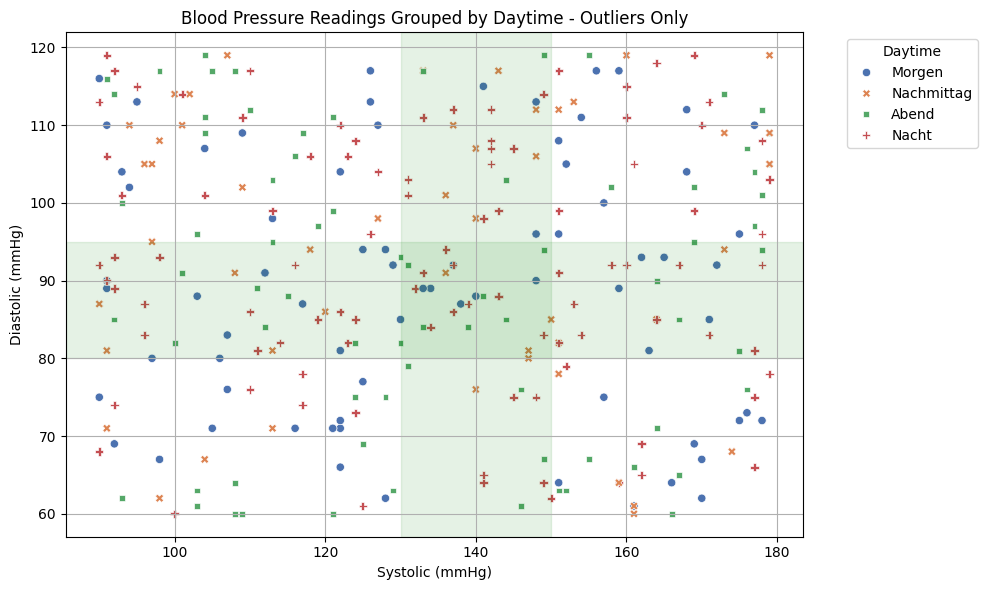

In [17]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample data for demonstration purposes
data = {
    'Systolic': [systolic for systolic, diastolic, pulse, recorded_at in results],
    'Diastolic': [diastolic for systolic, diastolic, pulse, recorded_at in results],
    'Daytime': [get_time_of_day(recorded_at) for systolic, diastolic, pulse, recorded_at in
                results]
}

df = pd.DataFrame(data)

# Create scatter plot using seaborn
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(data=df, x='Systolic', y='Diastolic', hue='Daytime', style='Daytime', palette='deep')
# TODO systolic_span, diastolic_span = get_blood_pressure_spans(tracker, user_id)
systolic_span = (130, 150)
diastolic_span = (80, 95)
plt.title('Blood Pressure Readings Grouped by Daytime - Outliers Only')
plt.xlabel('Systolic (mmHg)')
plt.ylabel('Diastolic (mmHg)')
plt.axvspan(systolic_span[0], systolic_span[1], color='green', alpha=0.1)
print(systolic_span, diastolic_span)
plt.axhspan(diastolic_span[0], diastolic_span[1], color='green', alpha=0.1)
plt.legend(title='Daytime', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


## details_ausreisser

In [18]:

from actions.utils import utils

pretty_change_date = pd.to_datetime(change_date).strftime('%d.%m.%Y')
since_date = False  # True
# change_date = "2024-03-01"
data = {
    'Datum': [recorded_at for systolic, diastolic, pulse, recorded_at in results],
    'Systolisch': [int(systolic) for systolic, diastolic, pulse, recorded_at in results],
    'Diastolisch': [int(diastolic) for systolic, diastolic, pulse, recorded_at in results],
    'Puls': [int(pulse) for systolic, diastolic, pulse, recorded_at in results],
    'Tageszeit_For_Hue': [utils.get_time_of_day(recorded_at) + " Ausreißer" for systolic, diastolic, pulse, recorded_at
                          in
                          results],
    'Tageszeit': [utils.get_time_of_day(recorded_at) for systolic, diastolic, pulse, recorded_at in results]

}

M


/var/folders/rs/j00tpx0d0lnf9l7ynl49vgvh0000gn/T/ipykernel_2159/1811939953.py:32: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=zeitspanne.capitalize(), y=typ.capitalize(), data=df[df[f'{typ.capitalize()}e Ausreißer']],


/Users/julianstrietzel/git/alpha_insights_rasa/tmp_systolisch_boxplot_Monat_and_outliers_2024-06-17 08:48:40.329915.png
/Users/julianstrietzel/git/alpha_insights_rasa/tmp_diastolisch_boxplot_Monat_and_outliers_2024-06-17 08:48:40.692334.png


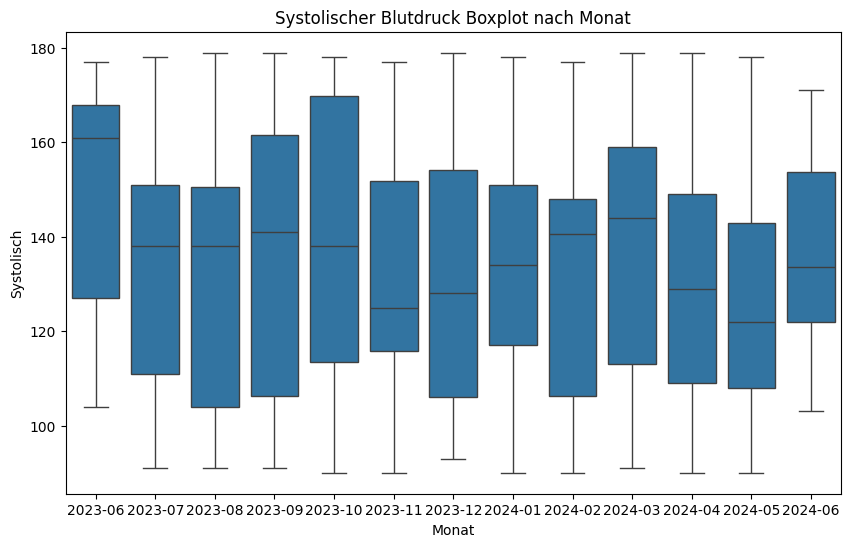

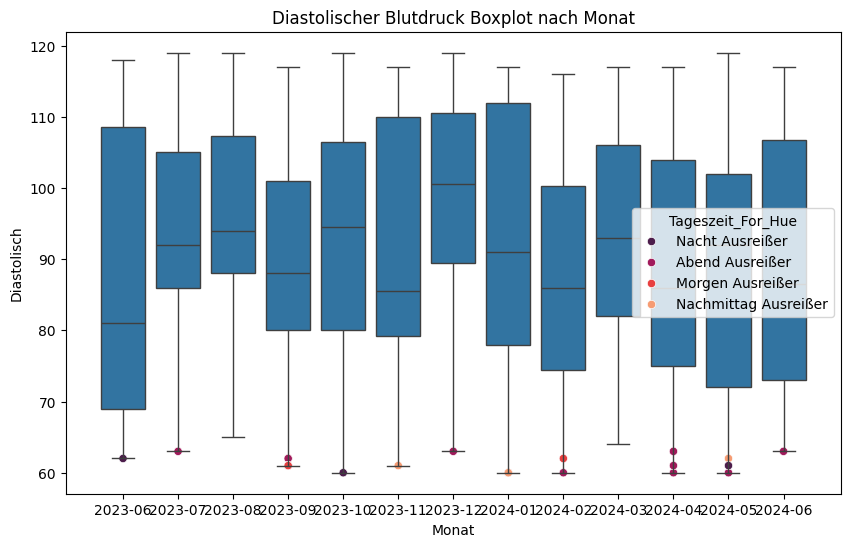

In [19]:
import pathlib
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import seaborn as sns

df = pd.DataFrame(data)


# Function to detect outliers
def detect_outliers(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 0.5 * iqr
    upper_bound = q3 + 0.5 * iqr
    return (series < lower_bound) | (series > upper_bound)


# Add outlier columns
df['Systolische Ausreißer'] = detect_outliers(df['Systolisch'])
df['Diastolische Ausreißer'] = detect_outliers(df['Diastolisch'])

print(timespan.capitalize()[0])
# Group by month for the boxplot
df[zeitspanne.capitalize()] = df['Datum'].dt.to_period(timespan.capitalize()[0]).astype(str)


def plot_box_and_outliers(typ=typ):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=zeitspanne.capitalize(), y=typ.capitalize(), data=df)
    sns.scatterplot(x=zeitspanne.capitalize(), y=typ.capitalize(), data=df[df[f'{typ.capitalize()}e Ausreißer']],
                    hue='Tageszeit_For_Hue', palette='rocket')
    plt.title(f'{typ.capitalize()}er Blutdruck Boxplot nach {zeitspanne.capitalize()}')

    if since_date:
        df["Änderungsdatum"] = pd.to_datetime(change_date).to_period(timespan.capitalize()[0])
        vline = plt.axvline(x=df["Änderungsdatum"].astype(str).iloc[0], color='red', linestyle='--',
                            label='Änderungsdatum' + f' ({change_date})')
        ax = plt.gca()
        trans = transforms.blended_transform_factory(ax.transData, ax.transAxes)
        vline.set_transform(trans + transforms.ScaledTranslation(-20 / 72., 0, plt.gcf().dpi_scale_trans))

        plt.legend()
        # filename = os.getcwd() + f'tmp_{typ}_boxplot_{zeitspanne}_and_outliers_' + str(datetime.now()) + ".png"
    filename = str(pathlib.Path().parent.absolute() / (f'tmp_{typ}_boxplot_{zeitspanne}_and_outliers_' + str(
        datetime.now()) + ".png"))
    plt.savefig(filename)
    return filename


if typ in ["diastolisch", "systolisch"]:
    dispatcher.utter_message(image=plot_box_and_outliers())
else:
    dispatcher.utter_message(image=plot_box_and_outliers("systolisch"))
    dispatcher.utter_message(image=plot_box_and_outliers("diastolisch"))


In [20]:


from actions.utils.utils import at_the_last_prefix

current_date_one_timespan_ago = (
        pd.to_datetime(datetime.now()) - pd.DateOffset(months=1 if zeitspanne == "Monat" else 1,
                                                       days=1 if zeitspanne == "Tag" else 0,
                                                       weeks=1 if zeitspanne == "Woche" else 0,
                                                       years=1 if zeitspanne == "Jahr" else 0)).strftime(
    "%Y-%m-%d")
df_recently = df[df['Datum'] >= current_date_one_timespan_ago] if not since_date else df[
    df['Datum'] >= pd.to_datetime(change_date)]

# In der letzten Woche waren 50% der systolischen und 30% der diastolischen Messungen extreme Ausreißer.
if len(df_recently) > 0:
    sys_outliers_quote = round(
        len(df_recently[df_recently['Systolische Ausreißer']]) / len(df_recently) * 100)
    dia_outliers_quote = round(len(df_recently[df_recently['Diastolische Ausreißer']]) / len(df_recently) * 100)
    dynamic_message = (
                          at_the_last_prefix[zeitspanne]
                          if not since_date
                          else f"Seit dem {pd.to_datetime(change_date).strftime('%d.%m.%Y')}"
                      ) + (
                          f" gab es keine Ausreißer."
                          if sys_outliers_quote == 0 and dia_outliers_quote == 0
                          else (
                                  " waren " + str(sys_outliers_quote) + "% der systolischen und "
                                  + str(dia_outliers_quote)
                                  + "% der diastolischen Messungen extreme Ausreißer."
                          )
                      )
    dispatcher.utter_message(dynamic_message)
else:
    dispatcher.utter_message(
        "Es gibt keine Messungen " + (
            at_the_last_prefix[zeitspanne].lower() + "."
            if not since_date
            else "seit dem " + pretty_change_date + "."
        )
    )


Im letzten Monat waren 0% der systolischen und 8% der diastolischen Messungen extreme Ausreißer.


In [21]:
import numpy as np

# set half of the sys outliers Tageszeit to Abend
data = {
    'Datum': pd.date_range(start='2024-05-16', periods=9, freq='D').to_series() + pd.to_timedelta(
        np.random.randint(0, 86400, size=9), unit='s'),
    'Systolisch': [136, 156, 145, 154, 152, 147, 122, 160, 147],
    'Diastolisch': [86, 81, 84, 82, 81, 80, 61, 82, 78],
    'Puls': [64, 61, 65, 63, 65, 63, 67, 63, 61],
    'Tageszeit_For_Hue': ['Morgen Ausreißer'] * 9,
    'Tageszeit': ['Morgen', 'Abend', 'Morgen', 'Abend', 'Morgen', 'Abend', 'Morgen', 'Abend', 'Morgen'],
    'Systolische Ausreißer': [
        True, True, False, True, True, True, False, True, True],
    'Diastolische Ausreißer': [True, True, False, True, True, True, False, True, False],
    'Monat': ['2024-05'] * 9
}

df_recently = pd.DataFrame(data)
recent_sys_outliers = df_recently[df_recently['Systolische Ausreißer']]
recent_dia_outliers = df_recently[df_recently['Diastolische Ausreißer']]

if len(df_recently["Tageszeit"].unique()) > 1:
    most_common_tageszeit = (pd.concat([recent_sys_outliers, recent_dia_outliers]))["Tageszeit"].mode()[0]
    count_sys_outliers = len(recent_sys_outliers)
    count_sys_at_tageszeit = len(recent_sys_outliers[recent_sys_outliers["Tageszeit"] == most_common_tageszeit])
    count_dia_outliers = len(recent_dia_outliers)
    count_dia_at_tageszeit = len(recent_dia_outliers[recent_dia_outliers["Tageszeit"] == most_common_tageszeit])
    dispatcher.utter_message(
        f"{round(count_sys_at_tageszeit / count_sys_outliers * 100)}% der systolischen und " +
        f"{round(count_dia_at_tageszeit / count_dia_outliers * 100)}% der diastolischen Ausreißer " +
        "wurden am " + most_common_tageszeit.capitalize() + " aufgenommen.")

else:
    dispatcher.utter_message(
        "Alle Ausreißer wurden am " + df["Tageszeit"].unique()[0].capitalize() + " aufgenommen.")

57% der systolischen und 67% der diastolischen Ausreißer wurden am Abend aufgenommen.


In [22]:
recent_sys_outliers
df_recently["sys_above"] = recent_sys_outliers["Systolisch"] > systolic_span[1]
df_recently["dia_above"] = recent_dia_outliers["Diastolisch"] > diastolic_span[1]
df_recently["sys_below"] = recent_sys_outliers["Systolisch"] < systolic_span[0]
df_recently["dia_below"] = recent_dia_outliers["Diastolisch"] < diastolic_span[0]
perc_above_sys = df_recently["sys_above"].sum() / len(recent_sys_outliers) * 100
perc_above_dia = df_recently["dia_above"].sum() / len(recent_dia_outliers) * 100
perc_below_sys = df_recently["sys_below"].sum() / len(recent_sys_outliers) * 100
perc_below_dia = df_recently["dia_below"].sum() / len(recent_dia_outliers) * 100

if perc_above_sys > 0 or perc_below_sys > 0:
    dispatcher.utter_message(
        f"{round(max(perc_above_sys, perc_below_sys))}% der systolischen Ausreißer liegen {f'über {systolic_span[1]} mmHg' if perc_above_sys > perc_below_sys else f'unter {systolic_span[0]} mmHg'}.")
else:
    dispatcher.utter_message("Keine systolischen Ausreißer liegen außerhalb des Zielkorridors.")

if perc_above_dia > 0 or perc_below_dia > 0:
    dispatcher.utter_message(
        f"{round(max(perc_above_dia, perc_below_dia))}% der diastolischen Ausreißer liegen {f'über {diastolic_span[1]} mmHg' if perc_above_dia > perc_below_dia else f'unter {diastolic_span[0]} mmHg'}.")
else:
    dispatcher.utter_message("Keine diastolischen Ausreißer liegen außerhalb des Zielkorridors.")


57% der systolischen Ausreißer liegen über 150 mmHg.
Keine diastolischen Ausreißer liegen außerhalb des Zielkorridors.


In [23]:
if since_date:
    query = f"""
                SELECT
                    systolic,
                    diastolic,
                    pulse,
                    recorded_at
                FROM 
                    bloodpressure
                WHERE 
                    user_id = {user_id}
                    AND CAST(recorded_at AS timestamp) <= '{change_date}'
            """

In [24]:
data = {
    'Datum': [recorded_at for systolic, diastolic, pulse, recorded_at in results],
    'Systolisch': [int(systolic) for systolic, diastolic, pulse, recorded_at in results],
    'Diastolisch': [int(diastolic) for systolic, diastolic, pulse, recorded_at in results],
    'Puls': [int(pulse) for systolic, diastolic, pulse, recorded_at in results],
    'Tageszeit_For_Hue': [utils.get_time_of_day(recorded_at) + " Ausreißer" for systolic, diastolic, pulse, recorded_at
                          in
                          results],
    'Tageszeit': [utils.get_time_of_day(recorded_at) for systolic, diastolic, pulse, recorded_at in results]

}

df_before = pd.DataFrame(data)
sys_percent_after = len(recent_sys_outliers) / len(df_recently) * 100
dia_percent_after = len(recent_dia_outliers) / len(df_recently) * 100

# Add outlier columns
df_before['Systolische Ausreißer'] = detect_outliers(df_before['Systolisch'])
df_before['Diastolische Ausreißer'] = detect_outliers(df_before['Diastolisch'])

sys_percent_before = len(df_before[df_before['Systolische Ausreißer']]) / len(df_before) * 100
dia_percent_before = len(df_before[df_before['Diastolische Ausreißer']]) / len(df_before) * 100

dispatcher.utter_message(
    f"Die Quote der Ausreißer im systolischen Blutwert hat sich seit dem {pretty_change_date} von {round(sys_percent_before)}% auf {round(sys_percent_after)}% " +
    ("erhöht." if sys_percent_after > sys_percent_before else "verringert.")
)
dispatcher.utter_message(
    f"Die Quote der Ausreißer im diastolischen Blutwert hat sich seit dem {pretty_change_date} von {round(dia_percent_before)}% auf {round(dia_percent_after)}% " +
    ("erhöht." if dia_percent_after > dia_percent_before else "verringert.")
)




Die Quote der Ausreißer im systolischen Blutwert hat sich seit dem 01.01.2021 von 0% auf 78% erhöht.
Die Quote der Ausreißer im diastolischen Blutwert hat sich seit dem 01.01.2021 von 7% auf 67% erhöht.


In [25]:
user_id = 25601
typ = "systolisch"
zeitspanne = "Monat"
change_date = "2024-03-01"
pretty_change_date = pd.to_datetime(change_date).strftime('%d.%m.%Y')
since_date = True



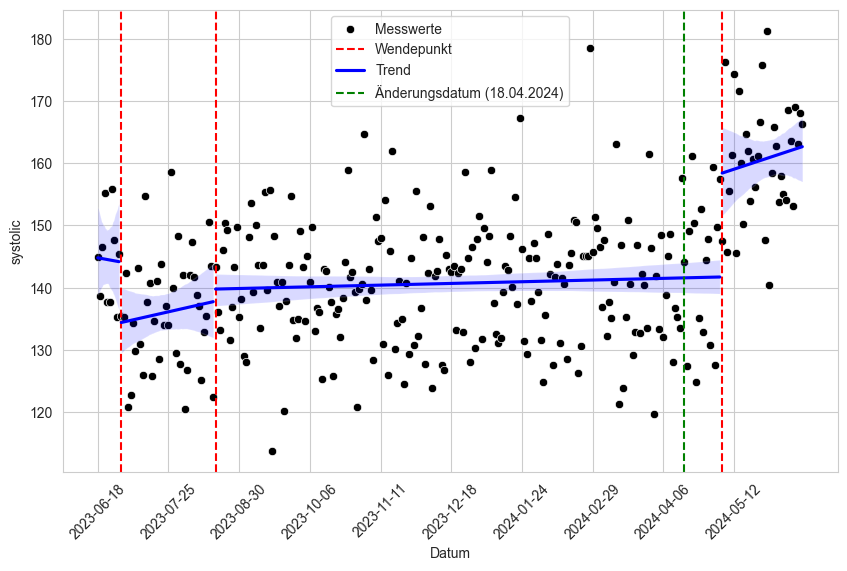

In [95]:
from sklearn.linear_model import LinearRegression
import pandas as pd
import ruptures as rpt
from datetime import datetime, timedelta

signal = mock_data['systolic'].values
mock_data['idx'] = range(len(mock_data))
mock_data['recorded_at'] = pd.to_datetime(mock_data['recorded_at'])

model = "l2"
algo = rpt.Dynp(model=model, min_size=7, jump=5).fit(signal)
inflection_result = algo.predict(n_bkps=3)[:-1]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=mock_data, x='idx', y='systolic', color='black', label='Messwerte')
segments = []
prev = 0
for bkp in inflection_result:
    segment_data = mock_data.iloc[prev:bkp]
    X = segment_data['recorded_at_ordinal'].values.reshape(-1, 1)
    y = segment_data['systolic'].values
    reg = LinearRegression().fit(X, y)
    segments.append((segment_data, reg))
    plt.axvline(x=mock_data['idx'].iloc[bkp], color='r', linestyle='--', label='Wendepunkt' if prev == 0 else None)
    sns.regplot(data=mock_data.iloc[prev:bkp], x='idx', y='systolic', scatter=False, color='blue', label='Trend' if prev == 0 else None)
    prev = bkp
sns.regplot(data=mock_data.iloc[prev:], x='idx', y='systolic', scatter=False, color='blue')
segment_data = mock_data.iloc[prev:]
X = segment_data['recorded_at_ordinal'].values.reshape(-1, 1)
y = segment_data['systolic'].values
segments.append((segment_data, LinearRegression().fit(X, y)))
change_date = datetime.strptime("2024-04-18", "%Y-%m-%d")
if change_date: 
    respective_id = mock_data[mock_data['recorded_at'] <= change_date].iloc[-1]['idx']
    plt.axvline(x=respective_id, color='g', linestyle='--', label='Änderungsdatum' + f' ({change_date.strftime("%d.%m.%Y")})')
# Adjust x-axis to display datetime values
ax = plt.gca()
plt.xlabel('Datum')
ax.set_xticks(range(0, len(mock_data),30 )) # <--- set the ticks first
ax.set_xticklabels(mock_data['recorded_at'][range(0, len(mock_data),30 )].dt.strftime('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.legend()

In [89]:
# use regression to describe the trends within the boundaries found by the inflection inflection_points
change_dates = [mock_data['recorded_at'].iloc[bkp] for bkp in inflection_result]
dispatcher.utter_message(f"Die drei signifikanten Wendepunkte im systolischen Blutdruck liegen am {change_dates[0].strftime('%d. %B %Y')}, {change_dates[1].strftime('%d. %B %Y')} und {change_dates[2].strftime('%d. %B %Y')}:")
summary = []
for i, (segment_data, reg) in enumerate(segments):
    if len(segment_data) < 7:
        continue
    start_date = segment_data['recorded_at'].iloc[0].strftime('%d. %B %Y')
    end_date = segment_data['recorded_at'].iloc[-1].strftime('%d. %B %Y')
    start_bp = reg.predict([[segment_data['recorded_at_ordinal'].iloc[0]]])[0]
    end_bp = reg.predict([[segment_data['recorded_at_ordinal'].iloc[-1]]])[0]
    trend = "Aufwärtstrend" if reg.coef_[0] > 0.05 else "Abwärtstrend" if reg.coef_[0] < -0.05 else "konstanten Verlauf"
    summary.append(f"{i+1}. Wir sehen einen {trend} von {start_bp:.0f} auf {end_bp:.0f} vom {start_date} bis zum {end_date}.")
for s in summary:
    dispatcher.utter_message(s)


Die drei signifikanten Wendepunkte im systolischen Blutdruck liegen am 30. June 2023, 18. August 2023 und 06. May 2024:
1. Wir sehen einen Abwärtstrend von 145 auf 144 vom 18. June 2023 bis zum 29. June 2023.
2. Wir sehen einen Aufwärtstrend von 134 auf 138 vom 30. June 2023 bis zum 17. August 2023.
3. Wir sehen einen konstanten Verlauf von 140 auf 142 vom 18. August 2023 bis zum 05. May 2024.
4. Wir sehen einen Aufwärtstrend von 158 auf 163 vom 06. May 2024 bis zum 17. June 2024.


In [86]:
summary


['1. Wir sehen einen Abwärtstrend von 145 auf 144 vom 18. June 2023 bis zum 29. June 2023.',
 '2. Wir sehen einen Aufwärtstrend von 134 auf 138 vom 30. June 2023 bis zum 17. August 2023.',
 '3. Wir sehen einen konstanten Verlauf von 140 auf 142 vom 18. August 2023 bis zum 05. May 2024.',
 '4. Wir sehen einen Aufwärtstrend von 158 auf 163 vom 06. May 2024 bis zum 17. June 2024.']

## Trendänderung seit medikation

In [125]:
change_date = datetime.strptime("2024-05-01", "%Y-%m-%d")
bp_data = pd.DataFrame(results, columns=['Systolic', 'Diastolic', 'Pulse', 'Date'])

/var/folders/rs/j00tpx0d0lnf9l7ynl49vgvh0000gn/T/ipykernel_2159/191291500.py:7: UserWarning: 
The markers list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(data=bp_data, x='Date_num', y='Systolic', hue='Event', style='Event', palette='deep', markers=['o'], s=20, legend=False)
/var/folders/rs/j00tpx0d0lnf9l7ynl49vgvh0000gn/T/ipykernel_2159/191291500.py:16: UserWarning: 
The markers list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(data=bp_data, x='Date_num', y='Diastolic', hue='Event', style='Event', palette=['green','orange'], markers=['o'], s = 20, legend=False)


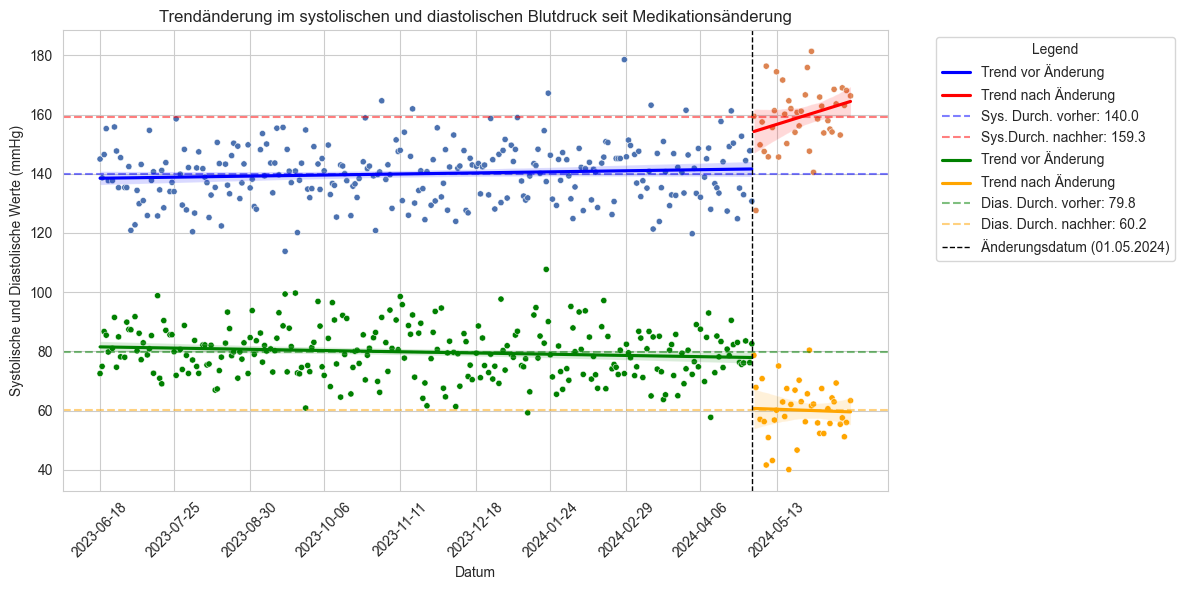

In [128]:
# Add a column to identify the event
bp_data['Event'] = bp_data['Date'] >= change_date
bp_data['Date_num'] = (bp_data['Date'] - bp_data['Date'].min()).dt.days

plt.figure(figsize=(12, 6))

sns.scatterplot(data=bp_data, x='Date_num', y='Systolic', hue='Event', style='Event', palette='deep', markers=['o'], s=20, legend=False)
sns.regplot(data=bp_data[bp_data['Event'] == False], x='Date_num', y='Systolic', scatter=False, label='Trend vor Änderung', color='blue')
sns.regplot(data=bp_data[bp_data['Event'] == True], x='Date_num', y='Systolic', scatter=False, label='Trend nach Änderung', color='red')
avg_before = bp_data[bp_data['Date'] < change_date]['Systolic'].mean()
avg_after = bp_data[bp_data['Date'] >= change_date]['Systolic'].mean()
plt.axhline(y=avg_before, color='blue', linestyle='--', label=f'Sys. Durch. vorher: {avg_before:.1f}', alpha=0.5)
plt.axhline(y=avg_after, color='red', linestyle='--', label=f'Sys.Durch. nachher: {avg_after:.1f}', alpha=0.5)

# Same for diastolic
sns.scatterplot(data=bp_data, x='Date_num', y='Diastolic', hue='Event', style='Event', palette=['green','orange'], markers=['o'], s = 20, legend=False)
sns.regplot(data=bp_data[bp_data['Event'] == False], x='Date_num', y='Diastolic', scatter=False, label='Trend vor Änderung', color='green')
sns.regplot(data=bp_data[bp_data['Event'] == True], x='Date_num', y='Diastolic', scatter=False, label='Trend nach Änderung', color='orange')
avg_before = bp_data[bp_data['Date'] < change_date]['Diastolic'].mean()
avg_after = bp_data[bp_data['Date'] >= change_date]['Diastolic'].mean()
plt.axhline(y=avg_before, color='green', linestyle='--', label=f'Dias. Durch. vorher: {avg_before:.1f}', alpha=0.5)
plt.axhline(y=avg_after, color='orange', linestyle='--', label=f'Dias. Durch. nachher: {avg_after:.1f}', alpha=0.5)

# Add vertical line for the event date
respective_id = bp_data[bp_data['Date'] <= change_date].iloc[-1]['Date_num']
plt.axvline(x=respective_id, color='black', linestyle='--', label='Änderungsdatum' + f' ({change_date.strftime("%d.%m.%Y")})', linewidth=1)

# Add titles and labels
plt.title('Trendänderung im systolischen und diastolischen Blutdruck seit Medikationsänderung')
plt.xlabel('Datum')
plt.ylabel('Systolische und Diastolische Werte (mmHg)')

xticks = bp_data['Date_num']
xlabels = bp_data['Date'].dt.strftime('%Y-%m-%d')
plt.xticks(ticks=xticks[::int(len(xticks)/10)], labels=xlabels[::int(len(xticks)/10)], rotation=45)

# Display the plot
plt.legend(title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()